In [1]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
# 2. LOAD DATA
df = pd.read_csv("financial_variance_analysis.csv")

print("Dataset loaded")
print("Shape:", df.shape)
df.head()

Dataset loaded
Shape: (10010, 10)


,Date,Department,Category,Region,Budget Amount,Actual Amount,Payment Method,Transaction ID,Variance,Variance %
0,2023-05-11 00:00:00,Sales,Travel,North,126096,43048,Card,TXN100000,-83048,-65.86
1,2023-11-11 00:00:00,Marketing,Salaries,East,19702,87896,Bank Transfer,TXN100001,68194,346.13
2,2021-05-02 00:00:00,IT,Training,Central,108523,103632,Card,TXN100002,-4891,-4.51
3,2022-04-12 00:00:00,Marketing,Salaries,North,114711,105574,Cash,TXN100003,-9137,-7.97
4,2021-11-27 00:00:00,Sales,Utilities,Central,121895,64314,UPI,TXN100004,-57581,-47.24


In [3]:
# 3. BASIC INSPECTION
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10010 entries, 0 to 10009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10010 non-null  object 
 1   Department      10009 non-null  object 
 2   Category        10009 non-null  object 
 3   Region          10007 non-null  object 
 4   Budget Amount   10010 non-null  int64  
 5   Actual Amount   10010 non-null  int64  
 6   Payment Method  10010 non-null  object 
 7   Transaction ID  10007 non-null  object 
 8   Variance        10010 non-null  int64  
 9   Variance %      10010 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 782.2+ KB


,Budget Amount,Actual Amount,Variance,Variance %
count,10010.000000,10010.000000,10010.000000,10010.000000
mean,79531.584316,89031.239261,9499.654945,73.413175
std,40490.798172,46947.492216,61647.495430,194.361817
min,10005.000000,8002.000000,-138773.000000,-94.200000
25%,44379.000000,48570.250000,-34996.500000,-38.705000
50%,79515.500000,89188.000000,9530.000000,11.760000
75%,114575.250000,130586.000000,54235.750000,101.722500
max,149992.000000,169973.000000,158737.000000,1500.090000


In [4]:
# 4. DATA CLEANING

# Convert Date
df["Date"] = pd.to_datetime(df["Date"])

# Remove duplicates
df = df.drop_duplicates()

# Drop the old column with %
# Remove old column with % symbol
if "Variance %" in df.columns:
    df = df.drop(columns=["Variance %"])


# Check missing values
df.isnull().sum()

# Rename 
df = df.rename(columns={
    "Budget Amount": "budget_amount",
    "Actual Amount": "actual_amount",
    "Payment Method": "payment_method",
    "Transaction ID": "transaction_id",
    "Variance %": "variance_pct"
})

df.columns

Index(['Date', 'Department', 'Category', 'Region', 'budget_amount',
       'actual_amount', 'payment_method', 'transaction_id', 'Variance'],
      dtype='object')

In [5]:
# 5. FEATURE ENGINEERING

df["Variance"] = df["actual_amount"] - df["budget_amount"]
df["variance_pct"] = (df["Variance"] / df["budget_amount"]) * 100

df["Month"] = df["Date"].dt.to_period("M")
df["Quarter"] = df["Date"].dt.quarter
df["Year"] = df["Date"].dt.year

df.head()

,Date,Department,Category,Region,budget_amount,actual_amount,payment_method,transaction_id,Variance,variance_pct,Month,Quarter,Year
0,2023-05-11,Sales,Travel,North,126096,43048,Card,TXN100000,-83048,-65.860931,2023-05,2,2023
1,2023-11-11,Marketing,Salaries,East,19702,87896,Bank Transfer,TXN100001,68194,346.127297,2023-11,4,2023
2,2021-05-02,IT,Training,Central,108523,103632,Card,TXN100002,-4891,-4.506879,2021-05,2,2021
3,2022-04-12,Marketing,Salaries,North,114711,105574,Cash,TXN100003,-9137,-7.965234,2022-04,2,2022
4,2021-11-27,Sales,Utilities,Central,121895,64314,UPI,TXN100004,-57581,-47.238197,2021-11,4,2021


In [6]:
# 6. CORE KPIs

total_budget = df["budget_amount"].sum()
total_actual = df["actual_amount"].sum()
total_variance = df["Variance"].sum()
variance_pct = (total_variance / total_budget) * 100

overspend_txn = (df["Variance"] > 0).sum()
saving_txn = (df["Variance"] < 0).sum()

print("========== KPI SUMMARY ==========")
print(f"Total Budget     : ${total_budget:,.0f}")
print(f"Total Actual     : ${total_actual:,.0f}")
print(f"Total Variance   : ${total_variance:,.0f}")
print(f"Variance %       : {variance_pct:.2f}%")
print(f"Overspend Txns   : {overspend_txn}")
print(f"Savings Txns     : {saving_txn}")
print("=================================")

# Add status
if total_variance > 0:
    print("\n Status: OVER BUDGET (Unfavorable)")
else:
    print("\n Status: UNDER BUDGET (Favorable)")

========== KPI SUMMARY ==========
Total Budget     : $795,469,256
Total Actual     : $890,267,029
Total Variance   : $94,797,773
Variance %       : 11.92%
Overspend Txns   : 5590
Savings Txns     : 4410

 Status: OVER BUDGET (Unfavorable)


Business Insight

Initial analysis shows significant variance across departments, with some consistently overspending against budget while others demonstrate cost efficiency. These insights can support budget reallocation and cost control strategies.

In [7]:
# 7. GROUPED BUSINESS ANALYSIS

dept_summary = df.groupby("Department")[["budget_amount","actual_amount","Variance"]].sum().sort_values("Variance", ascending=False)
cat_summary = df.groupby("Category")[["budget_amount","actual_amount","Variance"]].sum().sort_values("Variance", ascending=False)
region_summary = df.groupby("Region")[["budget_amount","actual_amount","Variance"]].sum().sort_values("Variance", ascending=False)

dept_summary, cat_summary, region_summary

(            budget_amount  actual_amount  Variance
 Department                                        
 Marketing       131939479      151816098  19876619
 HR              137371163      155439763  18068600
 Sales           134702488      151344999  16642511
 Operations      132622213      147803987  15181774
 IT              125771001      139663026  13892025
 Finance         132947149      144084529  11137380,
                 budget_amount  actual_amount  Variance
 Category                                              
 Salaries            127131160      147744247  20613087
 Utilities           137891618      155260320  17368702
 Marketing           130224132      146525696  16301564
 Travel              139968858      154885333  14916475
 Infrastructure      127813870      140825422  13011552
 Training            132399473      145010926  12611453,
          budget_amount  actual_amount  Variance
 Region                                         
 East         159685797      1810769

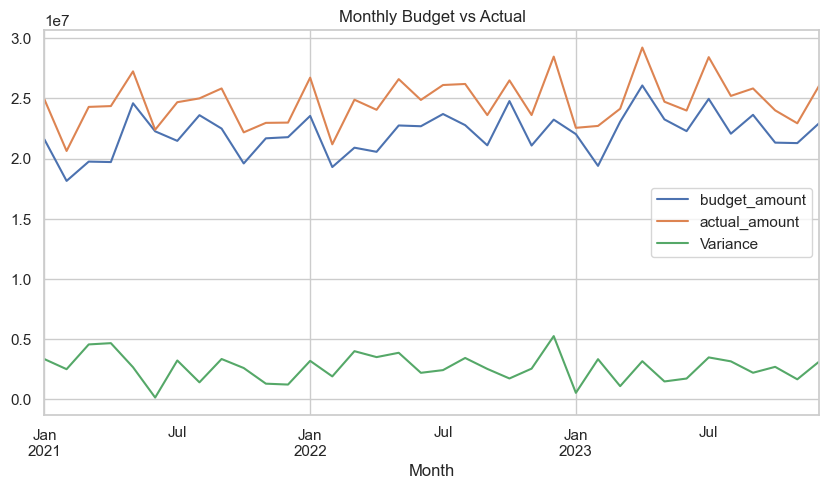

In [8]:
# 8. MONTHLY TREND ANALYSIS

monthly_summary = df.groupby("Month")[["budget_amount","actual_amount","Variance"]].sum()

monthly_summary.plot(title="Monthly Budget vs Actual")
plt.show()

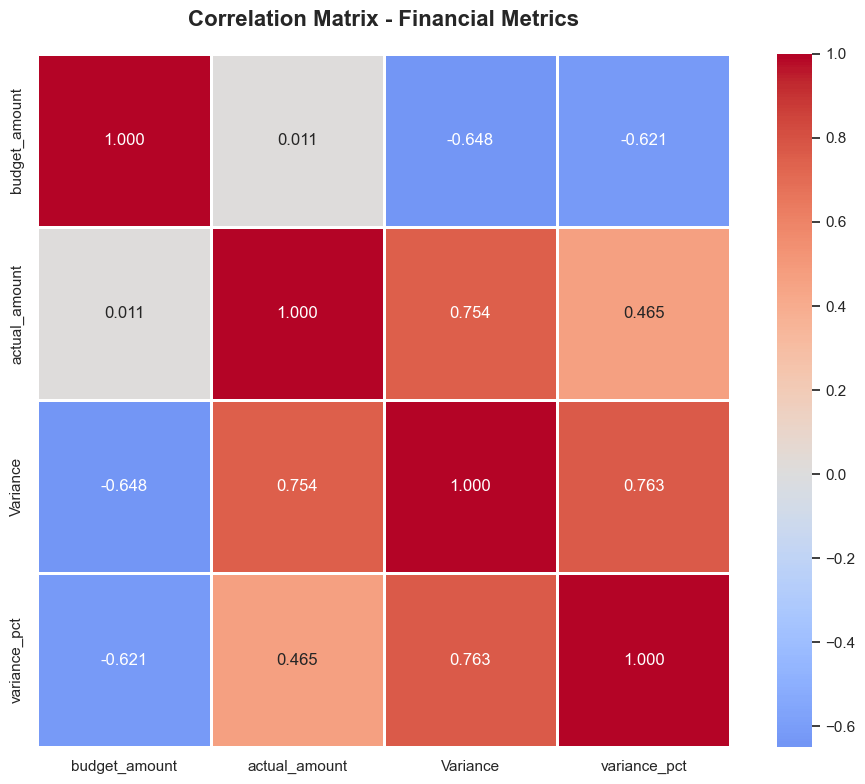

In [9]:
# 9. CORRELATION ANALYSIS

corr = df[["budget_amount", "actual_amount", "Variance", "variance_pct"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, 
            square=True, linewidths=2, fmt=".3f")
plt.title("Correlation Matrix - Financial Metrics", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()

In [10]:
# 10. OUTLIER DETECTION (Variance)

Q1 = df["Variance"].quantile(0.25)
Q3 = df["Variance"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["Variance"] < lower_bound) | (df["Variance"] > upper_bound)]

print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"\nLower Bound: ${lower_bound:,.2f}")
print(f"Upper Bound: ${upper_bound:,.2f}")
print(f"\nNumber of extreme variance cases: {outliers.shape[0]} ({outliers.shape[0]/len(df)*100:.1f}%)")

if outliers.shape[0] > 0:
    outliers.head(10)
else:
    print("No extreme outliers detected")

Q1 (25th percentile): $-35,006.00
Q3 (75th percentile): $54,225.25
IQR: $89,231.25

Lower Bound: $-168,852.88
Upper Bound: $188,072.12

Number of extreme variance cases: 0 (0.0%)
No extreme outliers detected


In [11]:
# 11. TOP BUSINESS CASES

top_overspend = df.sort_values("Variance", ascending=False).head(10)
top_savings = df.sort_values("Variance").head(10)

top_overspend[["Department","Category","Variance"]]
top_savings[["Department","Category","Variance"]]

,Department,Category,Variance
8906,IT,Infrastructure,-138773
318,Operations,Marketing,-137250
3797,IT,Marketing,-137073
8601,Sales,Training,-136857
7862,IT,Travel,-136694
7599,Sales,Travel,-136618
1745,Finance,Infrastructure,-135973
8875,Finance,Travel,-134782
2778,Sales,Utilities,-134731
8015,Finance,Travel,-134483


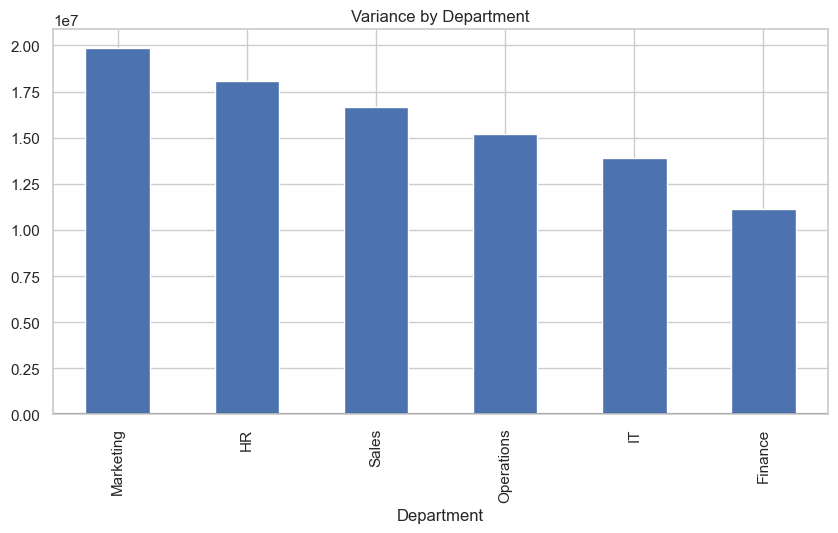

In [12]:
# 12. VISUALIZATION: VARIANCE BY DEPARTMENT

dept_summary["Variance"].plot(kind="bar", title="Variance by Department")
plt.axhline(0, color="black")
plt.show()


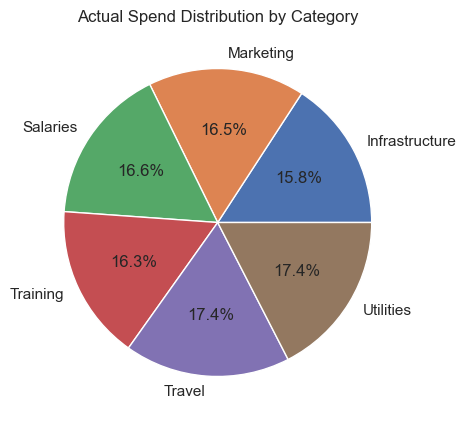

In [13]:
# 13. VISUALIZATION: CATEGORY COST DISTRIBUTION

df.groupby("Category")["actual_amount"].sum().plot(kind="pie", autopct="%1.1f%%")
plt.title("Actual Spend Distribution by Category")
plt.ylabel("")
plt.show()

**MYSQL CONNECTION**

In [14]:
!pip install mysql-connector-python sqlalchemy pymysql


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from sqlalchemy import create_engine

username = "root"
password = "7272"
host = "localhost"
port = "3306"
database = "financial_variance_analysis"

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")

df.to_sql("financial_variance_analysis", engine, if_exists="replace", index=False)

print("Cleaned data successfully uploaded to MySQL!")

Cleaned data successfully uploaded to MySQL!
